<a href="https://colab.research.google.com/github/ali77sina/Motion_Detection_Arduino/blob/main/ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this script, the aim is to use the saved data as a means of learning a simple neural network, to differenciate between vertical or horizental motion. 

In [ ]:
#importing libraries
import numpy as np
import tensorflow as tf

In [ ]:
num = 0

#Make sure the directory paths match your local machine. 
fileloch = r'C:\Users\ali77\OneDrive\Desktop\tinyML\acchor'    #The address to the directory with horizontal data
filelocv = r'C:\Users\ali77\OneDrive\Desktop\tinyML\accver'    #Address to the directory with vertical data



In [ ]:
hor_data = []   #for saving horizontal data
ver_data = []   #for saving vertical data

for j in range(100):   #make sure the number matches the number of datasets you have
    fileloc_h = fileloch + str(j)
    fileloc_v = filelocv + str(j)
    fileh = open(fileloc_h,'r')
    filev = open(fileloc_v,'r')

    #reading the data
    datah = fileh.read()
    datav = filev.read()

    #manual code for reading and cleaning the data
    datah = datah.split('b')
    data2h = []
    for i in datah:
        data2h.append(i.split(','))
    del(data2h[0])

    datav = datav.split('b')
    data2v = []
    for i in datav:
        data2v.append(i.split(','))
    del(data2v[0])

    for i in range(len(data2h)):
        data2h[i][-1] = float(data2h[i][-1][0:4])
        data2h[i][0] = float(data2h[i][0][1:5])
        data2h[i][1] = float(data2h[i][1])

    for i in range(len(data2v)):
        data2v[i][-1] = float(data2v[i][-1][0:4])
        data2v[i][0] = float(data2v[i][0][1:5])
        data2v[i][1] = float(data2v[i][1])

    data2h = np.array(data2h)
    data2v = np.array(data2v)

    hor_data.append(data2h)
    ver_data.append(data2v)

In [ ]:
#creating input arrays for the model
input_h = np.zeros(shape = [99,267]) #make sure the dim'n match your application
input_v = np.zeros(shape = [99,267])

#first set (index=0) seems to be corrupt, thus deleting it
hor_data.pop(0)
ver_data.pop(0)

for i in range(99):
    input_h[i,0:89] = hor_data[i][0:89,0]
    input_h[i,89:178] = hor_data[i][0:89,1]
    input_h[i,178:267] = hor_data[i][0:89,2]

    input_v[i,0:89] = ver_data[i][0:89,0]
    input_v[i,89:178] = ver_data[i][0:89,1]
    input_v[i,178:267] = ver_data[i][0:89,2]

inp = np.zeros(shape = [99*2,267])   #data
lab = np.zeros(shape = [99*2,])   #labels

#0 for horizental and 1 for vertical
#manual entries into the input and output vectors
inp[0:99] = input_h
inp[99:198] = input_v

lab[0:99] = 0
lab[99:198] = 1

#shuffling the data to be then fed into the model
from sklearn.utils import shuffle
inp, lab = shuffle(inp, lab)

Things to take into consideration before creating your model:

*Activation of your layers*

*Optimizer*

*Size of your model*

*Loss Function*

Look at this picture for reference:


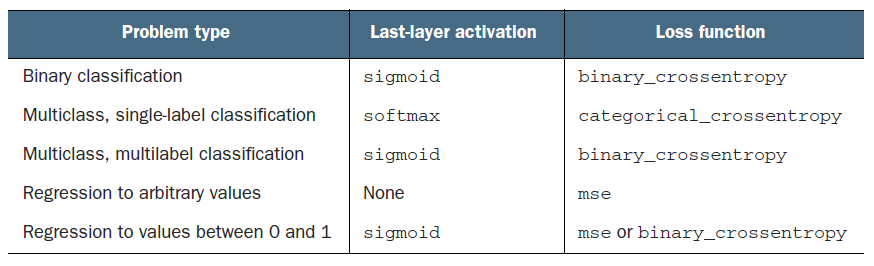

In [ ]:
#Creating a Tensorflow Neural Network 
#make sure the input dim'n match your application
Dense = tf.keras.layers.Dense
fc_model = tf.keras.Sequential(
    [
      tf.keras.Input(shape=(267,)),
      Dense(8, activation='relu'),
      Dense(1, activation = 'sigmoid')])

#I have manually set some of the data to be used as validation and the rest as training data
#This can be changed 
fc_model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])
history = fc_model.fit(inp[0:130], lab[0:130], validation_data=(inp[135:-1],lab[135:-1]), batch_size=50, epochs=10)


In [ ]:
#Converting your model into a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(fc_model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

The following is a function to convert hex values into a C array. Credits go to [Shawn Hymel](https://gist.github.com/ShawnHymel/79237fe6aee5a3653c497d879f746c0c). 


In [ ]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

# Writing the C array into a header file. 
c_model_name = 'tfliteModel'
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))


Now, you have the header file, which is consistent of your model in the form of a C array. Next step is to implement the model using the embedded software. 